In [65]:
import glob
from os import path
from time import perf_counter as clock

from astropy.io import fits
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

In [134]:
data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/pPXF (4800-5500)/"
ppxf_dir = "/home/carlos/Downloads/BADASS3-master/badass_data_files/indo_us_library/"

# Read a galaxy spectrum and define the wavelength range
#
file = data_folder + 'Data/Annealing_Bin02/Continuum/Binned_Spec/Bin0.fits'
hdu = fits.open(file)
gal_lin = hdu[1].data
h1 = hdu[1].header

lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)])
FWHM_gal = 2.71  # SAURON has an instrumental resolution FWHM of 4.2A.

#READING THE VARIANCE/LENDO A VARIÂNCIA DO ESPECTRO

var = hdu[2].data     #Read the variance/Lendo a variância
h_var = hdu[2].header #Read the variance header/Lendo o header da variância
lamRange_var = h_var['CRVAL1'] + np.array([0.,h_var['CDELT1']*(h_var['NAXIS1']-1)])

# If the galaxy is at significant redshift, one should bring the galaxy
# spectrum roughly to the rest-frame wavelength, before calling pPXF
# (See Sec2.4 of Cappellari 2017). In practice there is no
# need to modify the spectrum in any way, given that a red shift
# corresponds to a linear shift of the log-rebinned spectrum.
# One just needs to compute the wavelength range in the rest-frame
# and adjust the instrumental resolution of the galaxy observations.
# This is done with the following three commented lines:
#
z = 0.299  # Initial redshift estimate of the galaxy
#z = 1.23 # Initial estimate of the galaxy redshift
lamRange1 = lamRange1/(1+z) # Compute approximate restframe wavelength range
FWHM_gal = FWHM_gal/(1+z)   # Adjust resolution in Angstrom
lamRange_var = lamRange_var/(1+z)
z = 0.00

galaxy, logLam1, velscale = util.log_rebin(lamRange1, gal_lin)
median_galaxy = np.median(galaxy)
galaxy = galaxy/median_galaxy  # Normalize spectrum to avoid numerical issues



erro = np.sqrt(var) #1-sigma error from variance/1-sigma erro da variância
erro, loglam_var, velscale_var = util.log_rebin(lamRange_var, erro)
noise = erro/median_galaxy         #Normalizing the error/Normalizando o erro    

# Read the list of filenames from the Single Stellar Population library
# by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
# of the library is included for this example with permission
vazdekis = glob.glob(ppxf_dir + '/*.fits')
FWHM_tem = 1.35  # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
velscale_ratio = 2  # adopts 2x higher spectral sampling for templates than for galaxy


In [135]:
# Extract the wavelength range and logarithmically rebin one spectrum
# to a velocity scale 2x smaller than the SAURON galaxy spectrum, to determine
# the size needed for the array which will contain the template spectra.
#
hdu = fits.open(vazdekis[0])
ssp = hdu[0].data
h2 = hdu[0].header
lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)])
sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
templates = np.empty((sspNew.size, len(vazdekis)))

In [136]:
# Convolve the whole Vazdekis library of spectral templates
# with the quadratic difference between the SAURON and the
# Vazdekis instrumental resolution. Logarithmically rebin
# and store each template as a column in the array TEMPLATES.

# Quadratic sigma difference in pixels Vazdekis --> SAURON
# The formula below is rigorously valid if the shapes of the
# instrumental spectral profiles are well approximated by Gaussians.
#
FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

for j, file in enumerate(vazdekis):
    hdu = fits.open(file)
    ssp = hdu[0].data
    ssp = ndimage.gaussian_filter1d(ssp, sigma)
    sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
    templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates

In [137]:
# The galaxy and the template spectra do not have the same starting wavelength.
# For this reason an extra velocity shift DV has to be applied to the template
# to fit the galaxy spectrum. We remove this artificial shift by using the
# keyword VSYST in the call to PPXF below, so that all velocities are
# measured with respect to DV. This assume the redshift is negligible.
# In the case of a high-redshift galaxy one should de-redshift its
# wavelength to the rest frame before using the line below (see above).
#
c = 299792.458
dv = (np.mean(logLam2[:velscale_ratio]) - logLam1[0])*c  # km/s

goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)


 Best Fit:       Vel     sigma
 comp.  0:       157       255
chi2/DOF: 0.9959
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = nnls; Nonzero Templates (>0.1%):  5 / 50


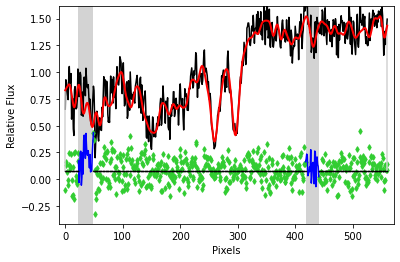

In [185]:
# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
#
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [200, 200.]  # (km/s), starting guess for [V, sigma]
t = clock()

pp = ppxf(templates, galaxy, noise, velscale, start,
          goodpixels=goodPixels, plot=True, moments=2,
          degree=2, vsyst=dv, velscale_ratio=velscale_ratio)

In [112]:
print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

Formal errors:
     dV    dsigma   dh3      dh4
      17      19


In [86]:
z_a = 0.299  # Initial redshift estimate of the galaxy
print('Best-fitting redshift z:', (z_a + 1)*(1 + pp.sol[0]/c) - 1)

Best-fitting redshift z: 0.2996000203556337
